In [13]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
from __future__ import print_function, division

import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import time
import os
import copy 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

plt.ion()

import sklearn.svm
from sklearn.metrics import accuracy_score
use_gpu = torch.cuda.is_available()

if use_gpu:
    print("CUDA kullanılıyor")

CUDA kullanılıyor


In [15]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
     'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/content/drive/My Drive/dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train','validation', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation','test']}
class_names = image_datasets['train'].classes
for x in ["train", "validation", "test"]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
print(image_datasets["train"].classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Loaded 4000 images under train
Loaded 250 images under validation
Loaded 250 images under test
['airport_inside', 'bar', 'bedroom', 'casino', 'inside_subway', 'kitchen', 'livingroom', 'restaurant', 'subway', 'warehouse']


In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [0]:
def extractFeature(model,phase):
    model.eval()
    trainFeatures = []
    trainClasses = []
    numpyTrainClasses = []
    numpyTrainFeatures = []
    for i, data in enumerate(dataloaders[phase]):
      inputs,labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      x = model(inputs)
      x = x.data.cpu().numpy()
      labels = labels.data.cpu().numpy()
      trainFeatures.append(x)
      trainClasses.append(labels)
  
  
    for i in trainFeatures:
      for j in i:
          numpyTrainFeatures.append(j)

    for i in trainClasses:
      for j in i:
        numpyTrainClasses.append(j)

    trainFeatures = np.array(trainFeatures)
    trainClasses = np.array(trainClasses)
    return numpyTrainFeatures,numpyTrainClasses

In [0]:
def GetAccuracy(trainFtr,trainCls,testFtr,testCls):
  clf = sklearn.svm.SVC(C=5.0, kernel='linear', tol=0.0001,gamma='scale')
  clf.fit(trainFtr,trainCls)
  predicted = clf.predict(testFtr)
  preds = predicted.tolist()
  plot_confusion_matrix(testCls, preds, classes=class_names,
                      title='Confusion matrix, without normalization')
  return accuracy_score(testCls,predicted)
  
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


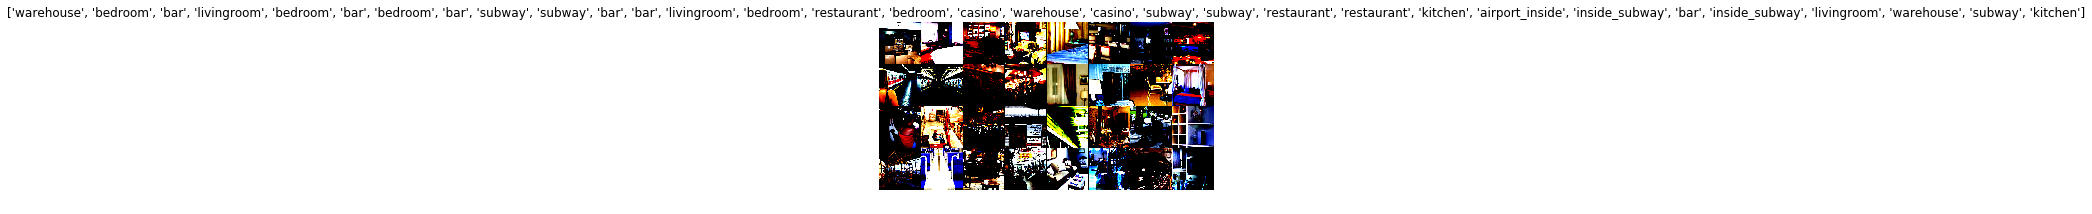

In [19]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    #plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title = [class_names[x] for x in classes])
inputs, classes = next(iter(dataloaders["train"]))
show_databatch(inputs,classes)

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    test_batches = len(dataloaders["test"])
    print("Hesaplama modeli")
    print('-' * 10)
    for i, data in enumerate(dataloaders["test"]):
        print("\rTest batch {}/{}".format(i, test_batches), end = '', flush=True)
        
        vgg.train(False)
        vgg.eval()
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data.cpu(), 1)
        loss = criterion(outputs, labels)       
        loss_test += loss.data
        acc_test += torch.sum(preds.cpu() == labels.data.cpu())
        
        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    
    avg_loss = loss_test / dataset_sizes["test"]
    avg_acc = acc_test.item() / dataset_sizes["test"]
    
    elapsed_time = time.time() - since
    print()
    print("Hesaplama {:.0f}m {:.0f}s zamanda tamamlandı".format(elapsed_time // 60, elapsed_time % 60))
    print("Ortalama kayıp (test): {:.4f}".format(avg_loss))
    print("Ortalama acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [0]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    loss_graph_train = []
    loss_graph_valid = []
    
    train_batches = len(dataloaders["train"])
    val_batches = len(dataloaders["validation"])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders["train"]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)
                
            inputs, labels = data
            
            inputs = inputs.to(device)
            labels = labels.to(device)
                
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data
            acc_train += torch.sum(preds == labels.data).data.cpu().numpy()
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train  / dataset_sizes["train"]
        avg_acc = acc_train  / dataset_sizes["train"]
        loss_graph_train.append(avg_loss.data.cpu().item())
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(dataloaders["validation"]):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data
            acc_val += torch.sum(preds == labels.data).data.cpu().numpy()
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes["validation"]
        avg_acc_val = acc_val / dataset_sizes["validation"]
        
        loss_graph_valid.append(avg_loss_val.data.cpu().item())
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    plt.figure(figsize=(8, 6))
    epochs = []
    for i in range(num_epochs):
      epochs.append(i+1)
    plot1, = plt.plot(np.array(epochs),np.array(loss_graph_train))
    plot2, = plt.plot(np.array(epochs),np.array(loss_graph_valid))
    plt.legend([plot1, plot2], ["train_loss", "validation_loss"])
    plt.xlabel('Epoch')
    plt.ylabel('Average Negative Log Likelihood')
    plt.title('Training and Validation Losses')
    vgg.load_state_dict(best_model_wts)
    return vgg

In [0]:
model = models.vgg16(pretrained=True)
new_classifier = nn.Sequential(*list(model.classifier.children())[:-1])
model.classifier = new_classifier
model = model.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 107454838.61it/s]


In [0]:
print("PART 1")
print()
trainFtr1 , trainCls1 = extractFeature(model,"train")
testFtr1 , testCls1 = extractFeature(model,"test")

print()

PART 1



KeyboardInterrupt: ignored

In [0]:
GetAccuracy(trainFtr1,trainCls1,testFtr1,testCls1)


In [0]:
vgg16 = models.vgg16(pretrained = True)

for param in vgg16.features.parameters():
    param.require_grad = False

num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] 
features.extend([nn.Linear(num_features, len(class_names))])
vgg16.classifier = nn.Sequential(*features)
vgg16 = vgg16.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(vgg16.parameters(), lr = 0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size = 4, gamma = 0.1)



In [25]:
print("PART 2")
print()
vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)
torch.save(vgg16.state_dict(), 'VGG16_FineTune.pt')

PART 2

Epoch 0/10
----------
Training batch 100/125
Validation batch 0/8
Epoch 0 result: 
Avg loss (train): 0.0100
Avg acc (train): 0.8898
Avg loss (val): 0.0137
Avg acc (val): 0.8720
----------

Epoch 1/10
----------
Training batch 0/125

KeyboardInterrupt: ignored

In [0]:

eval_model(vgg16, criterion)
print()

In [0]:
print("PART 3")
print()
ftr1,ftr2 = extractFeature(vgg16,"train")
ftr3,ftr4 = extractFeature(vgg16,"test")

In [0]:
GetAccuracy(ftr1,ftr2,ftr3,ftr4)